# Set Environment

In [1]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-b44ea435-16da-b96f-4ee9-ab9f797592ec)


In [2]:
import os
import sys
import numpy as np
import pandas as pd
import random as rn
import sklearn
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image, display
import matplotlib.cm as cmp
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [3]:
print( f"Python {sys.version}\n" )
print( f"NumPy {np.__version__}\n" )
%matplotlib inline
print(f'The scikit-learn version is {sklearn.__version__}')
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]

NumPy 1.23.5

The scikit-learn version is 1.2.2
TensorFlow 2.14.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [4]:
#Set random seed
np.random.seed(1234)
tf.random.set_seed(5678)

In [5]:
!git clone https://github.com/Napasakon/DADS7202_CNN_Image_Classifier.git
!unzip -o /content/DADS7202_CNN_Image_Classifier/dataset.zip -d /content/DADS7202_CNN_Image_Classifier/

Cloning into 'DADS7202_CNN_Image_Classifier'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (6/6), 10.46 MiB | 16.90 MiB/s, done.
Archive:  /content/DADS7202_CNN_Image_Classifier/dataset.zip
   creating: /content/DADS7202_CNN_Image_Classifier/sepak trakaw/
  inflating: /content/DADS7202_CNN_Image_Classifier/__MACOSX/._sepak trakaw  
  inflating: /content/DADS7202_CNN_Image_Classifier/sepak trakaw/IMG (91).jpg  
  inflating: /content/DADS7202_CNN_Image_Classifier/__MACOSX/sepak trakaw/._IMG (91).jpg  
  inflating: /content/DADS7202_CNN_Image_Classifier/sepak trakaw/IMG (29).jpg  
  inflating: /content/DADS7202_CNN_Image_Classifier/__MACOSX/sepak trakaw/._IMG (29).jpg  
  inflating: /content/DADS7202_CNN_Image_Classifier/sepak trakaw/IMG (68).jpg  
  inflating: /content/DADS7202_CNN_Image_Classifier/__MACOSX/sepak trakaw

# Generate npy *object*

In [6]:
def generate_npy_dataset(srcPath, desPath, imgSize=(224,224), outName='out', classNo=1):
  arr = os.listdir(srcPath)
  x = []
  y = []

  for filename in arr:
      file_destination = srcPath + filename

      img = cv2.imread(file_destination)
      RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #CAUTION! SAVED IN RGB NOT BGR
      img = cv2.resize(RGB_img, imgSize)
      x.append(img)
      y.append(classNo)
  # print(f'x shape: {np.array(x).shape}')
  # print(f'y shape: {np.array(y).shape}')
  np.save(desPath + 'x_' + outName, x)
  np.save(desPath + 'y_' + outName, y)

In [7]:
generate_npy_dataset(srcPath='/content/DADS7202_CNN_Image_Classifier/sepak trakaw/',
                    desPath='/content/DADS7202_CNN_Image_Classifier/',
                     imgSize=(224,224),
                     outName='sepak_trakaw',
                     classNo=0)

In [8]:
generate_npy_dataset(srcPath='/content/DADS7202_CNN_Image_Classifier/kendo/',
                    desPath='/content/DADS7202_CNN_Image_Classifier/',
                     imgSize=(224,224),
                     outName='kendo',
                     classNo=1)

In [9]:
generate_npy_dataset(srcPath='/content/DADS7202_CNN_Image_Classifier/handball/',
                    desPath='/content/DADS7202_CNN_Image_Classifier/',
                     imgSize=(224,224),
                     outName='handball',
                     classNo=2)

# Load image

In [10]:
x0 = np.load('/content/DADS7202_CNN_Image_Classifier/x_sepak_trakaw.npy')
x1 = np.load('/content/DADS7202_CNN_Image_Classifier/x_kendo.npy')
x2 = np.load('/content/DADS7202_CNN_Image_Classifier/x_handball.npy')

print(x0.shape)
print(x1.shape)
print(x2.shape)

(125, 224, 224, 3)
(140, 224, 224, 3)
(130, 224, 224, 3)


In [11]:
y0 = np.load('/content/DADS7202_CNN_Image_Classifier/y_sepak_trakaw.npy')
y1 = np.load('/content/DADS7202_CNN_Image_Classifier/y_kendo.npy')
y2 = np.load('/content/DADS7202_CNN_Image_Classifier/y_handball.npy')

print(y0.shape)
print(y1.shape)
print(y2.shape)

(125,)
(140,)
(130,)


In [12]:
x = np.concatenate((x0, x1, x2))
y = np.concatenate((y0, y1, y2))
print(x.shape)
print(y.shape)

(395, 224, 224, 3)
(395,)


In [13]:
#Train Test Split
from sklearn.model_selection import train_test_split

test_size = 0.3
x_train, x_test = train_test_split(x, test_size = test_size, random_state = 3)
y_train, y_test = train_test_split(y, test_size = test_size, random_state = 3)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(276, 224, 224, 3)
(276,)
(119, 224, 224, 3)
(119,)


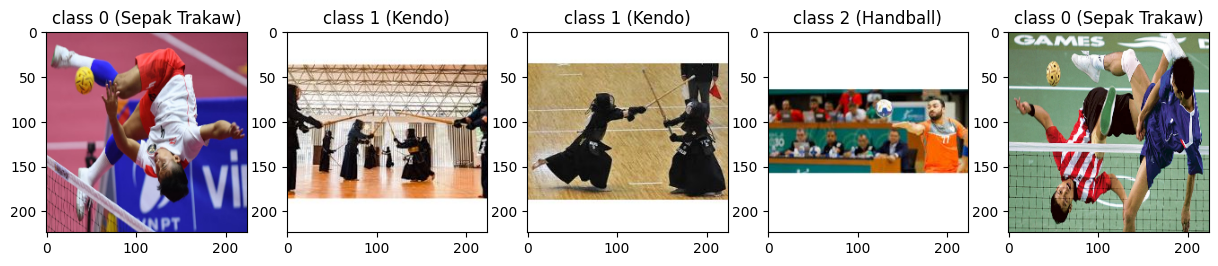

In [14]:
#visualize the first 5 image of x_train
label = ['Sepak Trakaw','Kendo','Handball']
plt.figure(figsize = (15,5))
for i in range(5):
  plt.subplot(150 + 1 + i).set_title(f'class {y_train[i]} ({label[y_train[i]]})')
  plt.imshow(x_train[i])
plt.show()

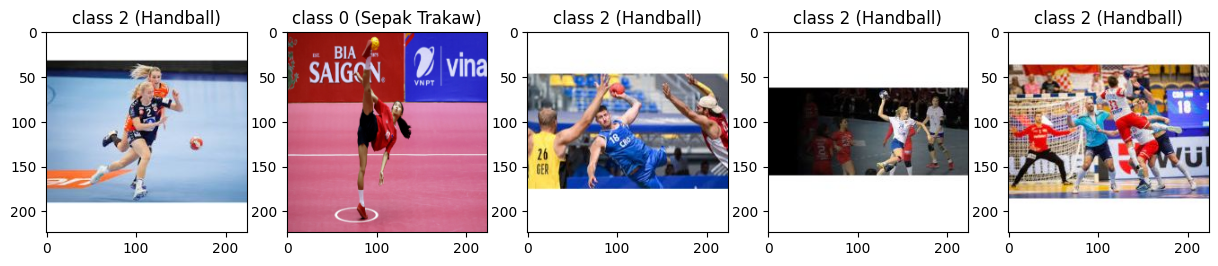

In [15]:
#visualize the first 5 image of x_test
plt.figure(figsize = (15,5))
for i in range(5):
  plt.subplot(150 + 1 + i).set_title(f'class {y_test[i]} ({label[y_test[i]]})')
  plt.imshow(x_test[i])
plt.show()

# Prepare Model

In [16]:
#Load VGG16 model
x_extractor = VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
x_extractor.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [17]:
#Pre-processing
x_train_vgg16 = preprocess_input(x_train)
x_test_vgg16 = preprocess_input(x_test)

print(x_train_vgg16.shape)
print(x_test_vgg16.shape)

(276, 224, 224, 3)
(119, 224, 224, 3)


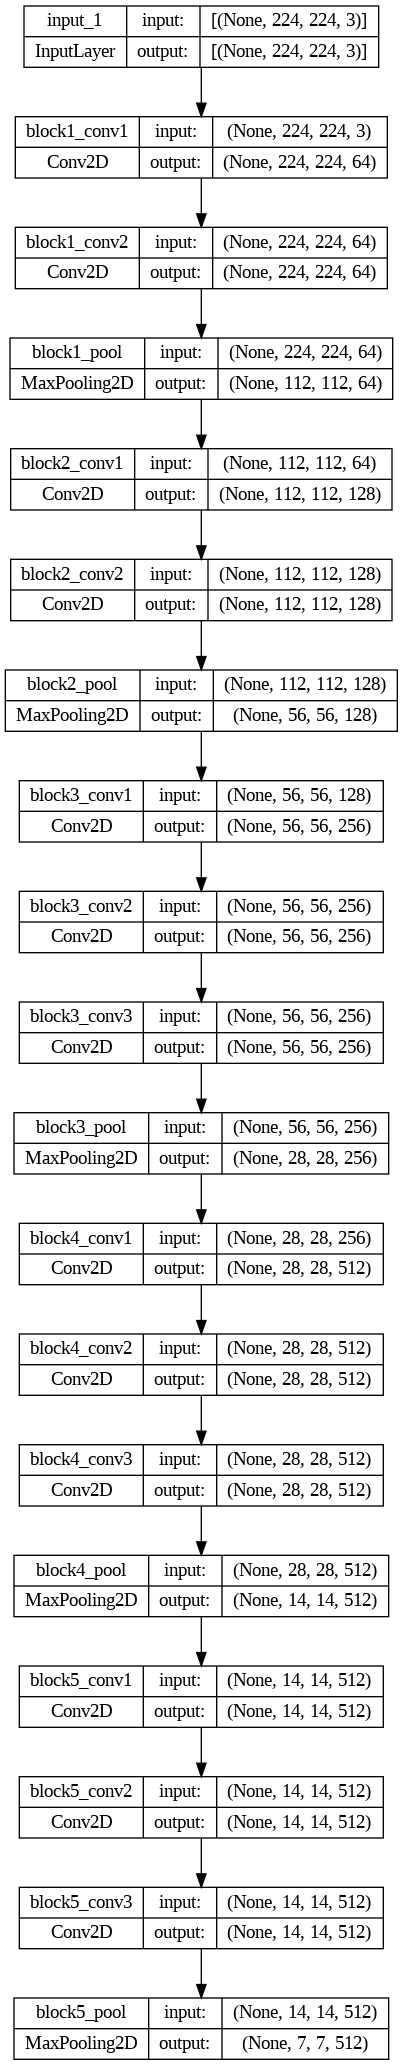

In [18]:
# plot model
tf.keras.utils.plot_model(x_extractor, to_file = 'VGG16_Model.png', show_shapes = True, show_dtype = False, show_layer_names = True, dpi = 96)

In [19]:
# Freeze all layers
x_extractor.trainable = False

for i, layer in enumerate(x_extractor.layers):
  print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

Layer 0: Name = input_1, Trainable = False
Layer 1: Name = block1_conv1, Trainable = False
Layer 2: Name = block1_conv2, Trainable = False
Layer 3: Name = block1_pool, Trainable = False
Layer 4: Name = block2_conv1, Trainable = False
Layer 5: Name = block2_conv2, Trainable = False
Layer 6: Name = block2_pool, Trainable = False
Layer 7: Name = block3_conv1, Trainable = False
Layer 8: Name = block3_conv2, Trainable = False
Layer 9: Name = block3_conv3, Trainable = False
Layer 10: Name = block3_pool, Trainable = False
Layer 11: Name = block4_conv1, Trainable = False
Layer 12: Name = block4_conv2, Trainable = False
Layer 13: Name = block4_conv3, Trainable = False
Layer 14: Name = block4_pool, Trainable = False
Layer 15: Name = block5_conv1, Trainable = False
Layer 16: Name = block5_conv2, Trainable = False
Layer 17: Name = block5_conv3, Trainable = False
Layer 18: Name = block5_pool, Trainable = False


# Fine-tune

In [20]:
# Unfreeze only layer 17
layer = x_extractor.get_layer('block5_conv3')
print(f'Layer {layer}: Name = {layer.name}, Trainable = {layer.trainable}')

layer.trainable=True

for i, layer in enumerate(x_extractor.layers):
  print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

Layer <keras.src.layers.convolutional.conv2d.Conv2D object at 0x793af02b3970>: Name = block5_conv3, Trainable = False
Layer 0: Name = input_1, Trainable = False
Layer 1: Name = block1_conv1, Trainable = False
Layer 2: Name = block1_conv2, Trainable = False
Layer 3: Name = block1_pool, Trainable = False
Layer 4: Name = block2_conv1, Trainable = False
Layer 5: Name = block2_conv2, Trainable = False
Layer 6: Name = block2_pool, Trainable = False
Layer 7: Name = block3_conv1, Trainable = False
Layer 8: Name = block3_conv2, Trainable = False
Layer 9: Name = block3_conv3, Trainable = False
Layer 10: Name = block3_pool, Trainable = False
Layer 11: Name = block4_conv1, Trainable = False
Layer 12: Name = block4_conv2, Trainable = False
Layer 13: Name = block4_conv3, Trainable = False
Layer 14: Name = block4_pool, Trainable = False
Layer 15: Name = block5_conv1, Trainable = False
Layer 16: Name = block5_conv2, Trainable = False
Layer 17: Name = block5_conv3, Trainable = True
Layer 18: Name = blo

# Data Augmentation

In [21]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        #rescale=1. / 255,
        #featurewise_center=True,
        samplewise_center=True,
        #featurewise_std_normalization=True,
        samplewise_std_normalization=True,
        #zca_whitening=False,
        rotation_range=0,
        width_shift_range=5.0,
        height_shift_range=5.0,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.3)
train_datagen.fit(x_train_vgg16)

In [22]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        #rescale=1. / 255,
        # featurewise_center=True,
        samplewise_center=True,
        # featurewise_std_normalization=True,
        samplewise_std_normalization=True
        )
test_datagen.fit(x_test_vgg16)

===== Train batch no. 1/1 =====


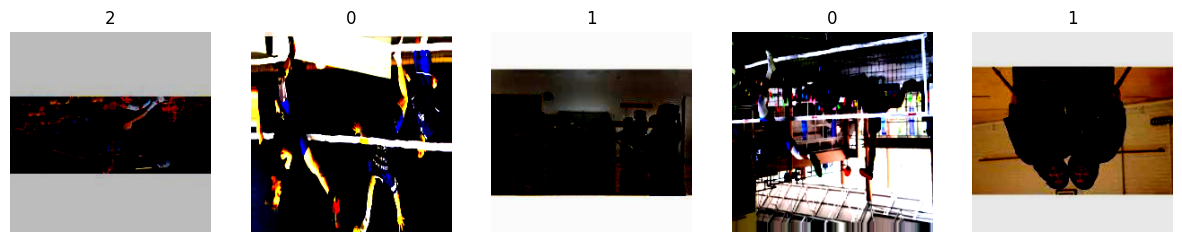

In [23]:
n_show = 1    # show 'n_show' batches of generated data (1 batch includes 5 images)

for b, (x_batch, y_batch) in enumerate( train_datagen.flow( x_train, y_train, batch_size=5, subset='training' ) ):
  print( f"===== Train batch no. {b+1}/{n_show} =====" )
  plt.figure(figsize=(15,5))
  for i in range(5):
      plt.subplot(150 + 1 + i).set_title( y_batch[i] )
      plt.imshow( x_batch[i])
      plt.axis( "off" )        # remove all tick marks
  plt.show()

  if b+1 >= n_show:
    break

===== Train batch no. 1/1 =====


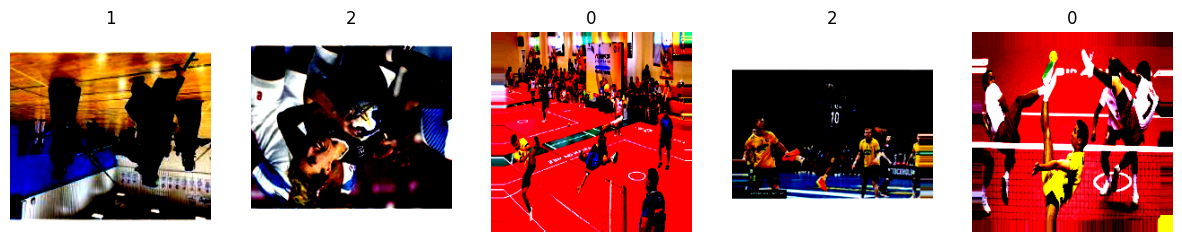

In [24]:
n_show = 1    # show 'n_show' batches of generated data (1 batch includes 5 images)

for b, (x_batch, y_batch) in enumerate( train_datagen.flow( x_train, y_train, batch_size=5, subset='validation' ) ):
  print( f"===== Train batch no. {b+1}/{n_show} =====" )
  plt.figure(figsize=(15,5))
  for i in range(5):
      plt.subplot(150 + 1 + i).set_title( y_batch[i] )
      plt.imshow( x_batch[i])
      plt.axis( "off" )        # remove all tick marks
  plt.show()

  if b+1 >= n_show:
    break

===== Train batch no. 1/1 =====


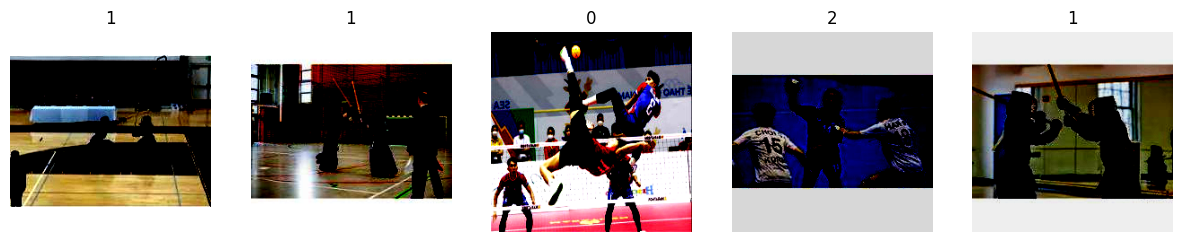

In [25]:
n_show = 1    # show 'n_show' batches of generated data (1 batch includes 5 images)

for b, (x_batch, y_batch) in enumerate( test_datagen.flow( x_test,y_test,batch_size=5 ) ):
  print( f"===== Train batch no. {b+1}/{n_show} =====" )
  plt.figure(figsize=(15,5))
  for i in range(5):
      plt.subplot(150 + 1 + i).set_title( y_batch[i] )
      plt.imshow( x_batch[i])
      plt.axis( "off" )        # remove all tick marks
  plt.show()

  if b+1 >= n_show:
    break

# Train Model

In [26]:
x = x_extractor.output

#Add our custom layer(s) to the end of the existing model
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)

x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(3, activation = 'softmax')(x)

#construct the main model
model = tf.keras.models.Model(inputs = x_extractor.inputs, outputs = new_outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [27]:
model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) ,
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                       metrics=['acc']
                     )

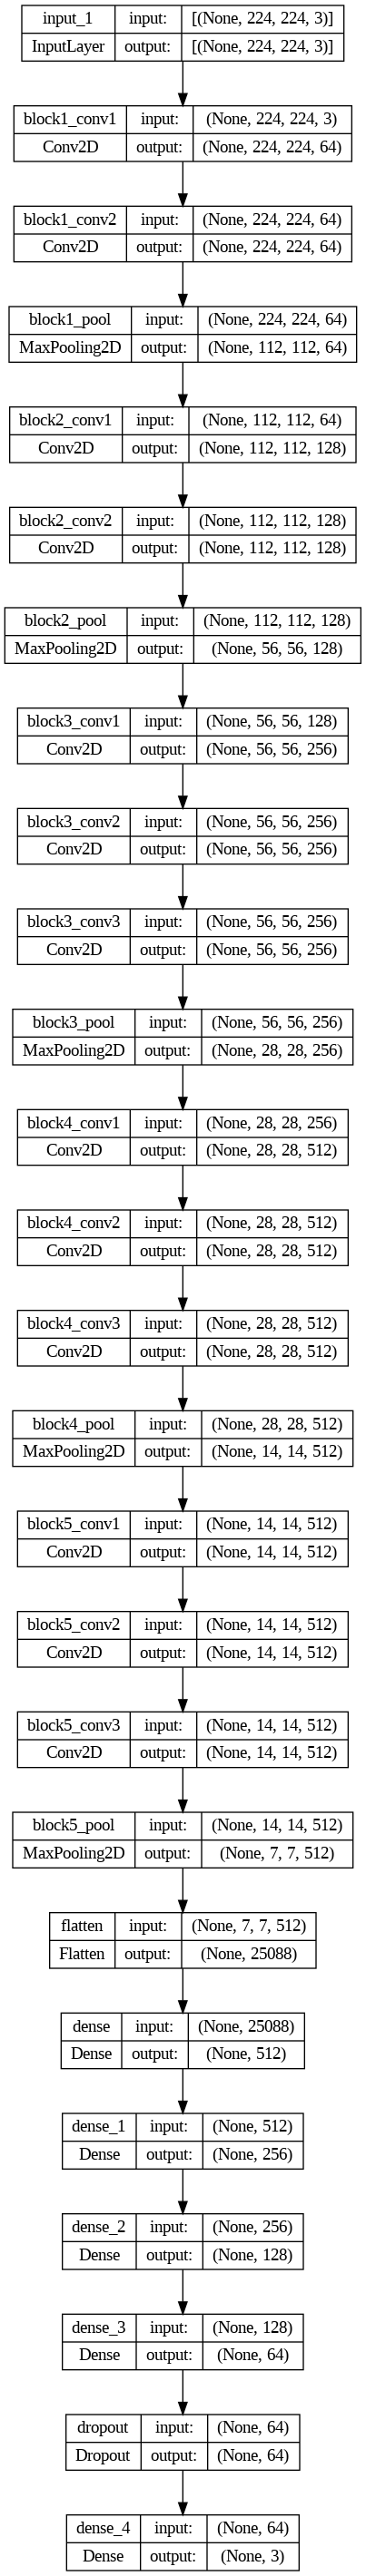

In [28]:
tf.keras.utils.plot_model(model, to_file = 'VGG16_Model.png', show_shapes = True, show_dtype = False, show_layer_names = True, dpi = 96)

In [29]:
history = model.fit(train_datagen.flow(x_train_vgg16 ,y_train,batch_size=32,subset='training'),epochs = 30, verbose = 2,
                    validation_data=train_datagen.flow(x_train_vgg16 ,y_train,batch_size=32,subset='validation'))

Epoch 1/30
7/7 - 22s - loss: 1.5939 - acc: 0.4381 - val_loss: 0.4306 - val_acc: 0.9390 - 22s/epoch - 3s/step
Epoch 2/30
7/7 - 3s - loss: 0.4974 - acc: 0.7784 - val_loss: 1.3587 - val_acc: 0.4878 - 3s/epoch - 450ms/step
Epoch 3/30
7/7 - 3s - loss: 0.7247 - acc: 0.7526 - val_loss: 0.1828 - val_acc: 0.9268 - 3s/epoch - 491ms/step
Epoch 4/30
7/7 - 3s - loss: 0.2174 - acc: 0.9330 - val_loss: 0.1122 - val_acc: 0.9512 - 3s/epoch - 448ms/step
Epoch 5/30
7/7 - 3s - loss: 0.0986 - acc: 0.9742 - val_loss: 0.1231 - val_acc: 0.9634 - 3s/epoch - 449ms/step
Epoch 6/30
7/7 - 3s - loss: 0.1049 - acc: 0.9742 - val_loss: 0.1278 - val_acc: 0.9756 - 3s/epoch - 435ms/step
Epoch 7/30
7/7 - 3s - loss: 0.3019 - acc: 0.9536 - val_loss: 0.2621 - val_acc: 0.9146 - 3s/epoch - 443ms/step
Epoch 8/30
7/7 - 3s - loss: 0.1704 - acc: 0.9536 - val_loss: 0.3230 - val_acc: 0.8415 - 3s/epoch - 448ms/step
Epoch 9/30
7/7 - 4s - loss: 0.1508 - acc: 0.9536 - val_loss: 0.1152 - val_acc: 0.9634 - 4s/epoch - 614ms/step
Epoch 10/30

# Model Evaluate

In [30]:
results = model.evaluate(test_datagen.flow(x_test_vgg16, y_test, batch_size = 128))
print(f'{model.metrics_names}: {results}')

1/1 [==============================] - 5s 5s/step - loss: 1.0389e-04 - acc: 1.0000
['loss', 'acc']: [0.0001038863993017003, 1.0]


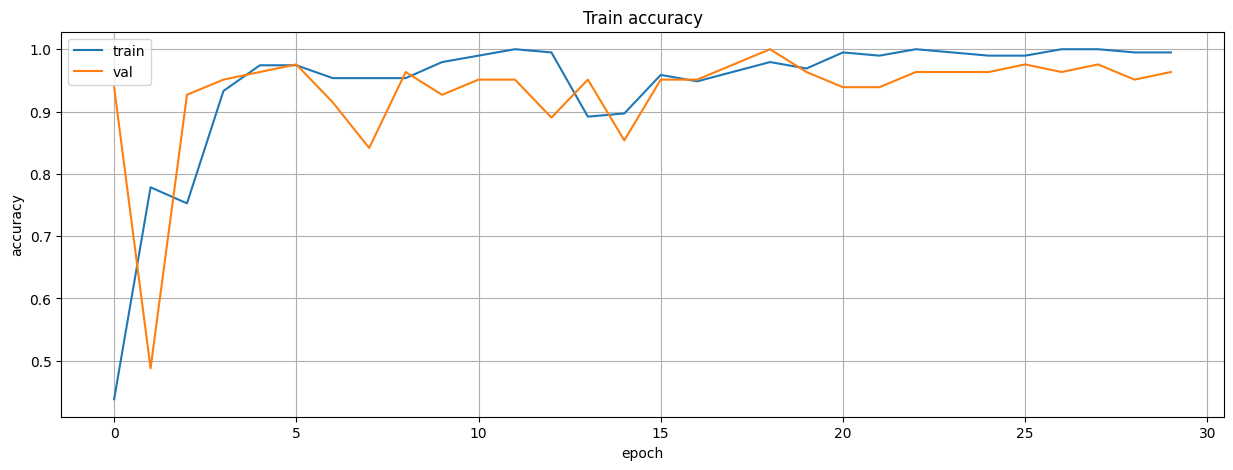

In [31]:
#Summarize history of accuracy
plt.figure(figsize = (15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.grid()
plt.show()

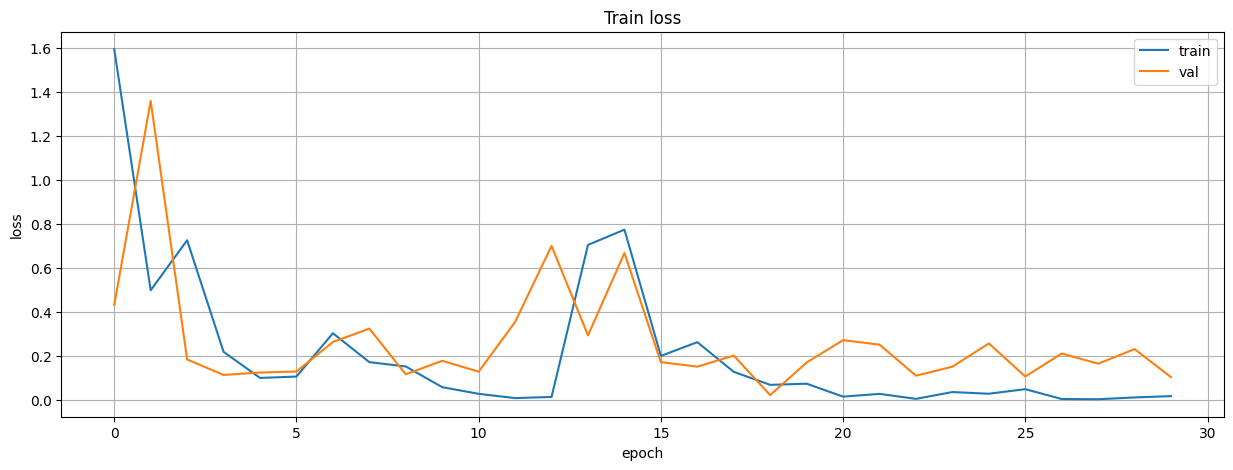

In [32]:
#Summarize history for loss
plt.figure(figsize = (15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper right')
plt.grid()
plt.show()

1/1 [==============================] - 0s 19ms/step


[Text(0.5, 23.52222222222222, 'Predict'),
 Text(50.72222222222221, 0.5, 'Actual')]

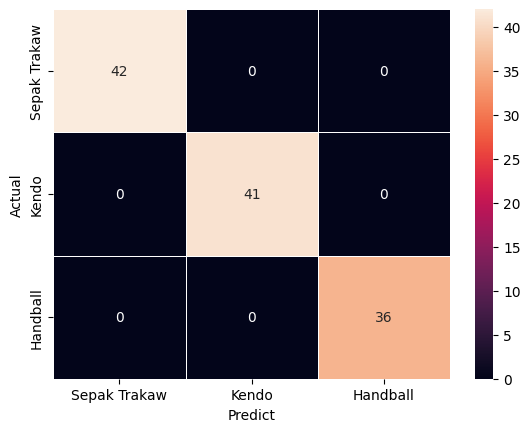

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred = []
for i in range(len(x_test_vgg16)):
  x_input = x_test_vgg16[i][np.newaxis, ...]
  y_pred.append(np.argmax(model.predict(x_input)))
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot = True, xticklabels = label, yticklabels = label, linewidth=.5, )
ax.set(xlabel='Predict',ylabel='Actual')

1/1 [==============================] - 0s 32ms/step


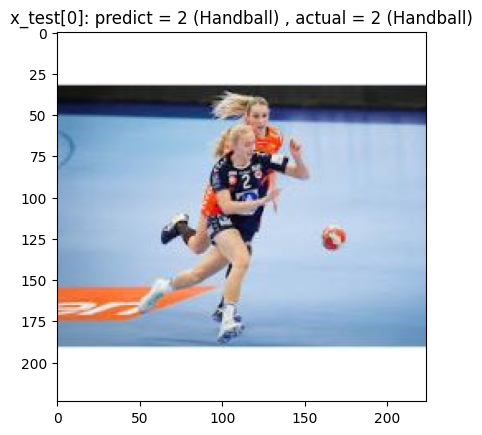

1/1 [==============================] - 0s 29ms/step


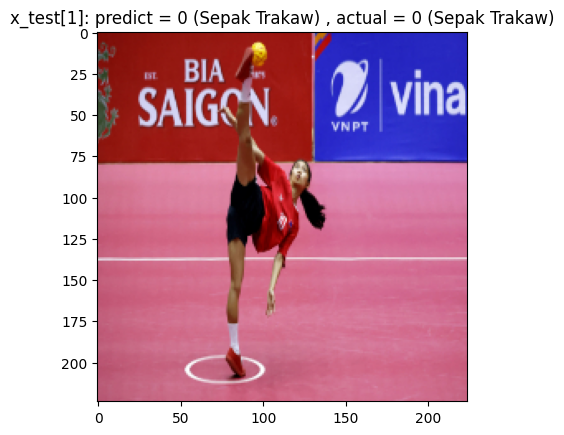

1/1 [==============================] - 0s 32ms/step


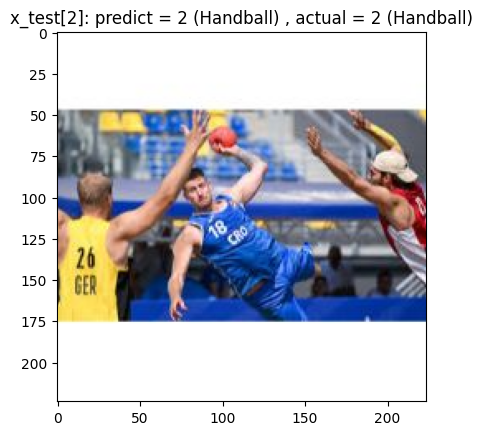

1/1 [==============================] - 0s 42ms/step


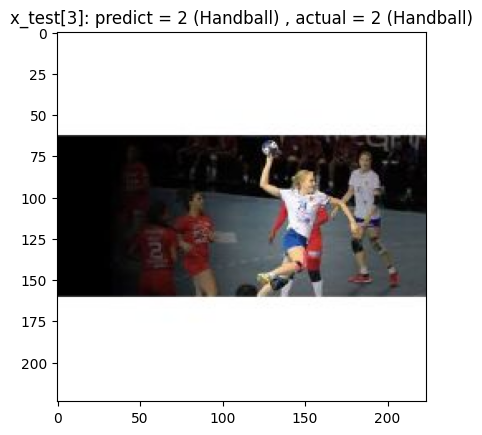

1/1 [==============================] - 0s 27ms/step


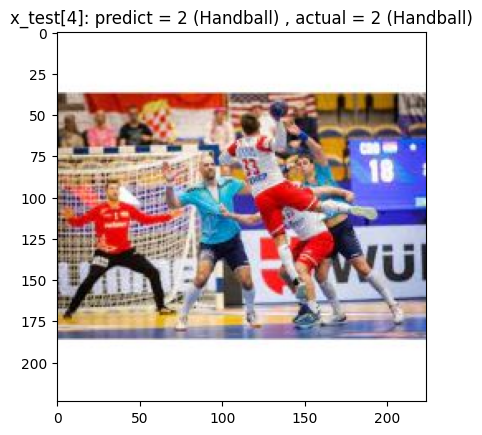

In [34]:
for i in range(5):
  y_pred = model.predict(x_test_vgg16[i].reshape(1,224,224,3))
  plt.imshow(x_test[i])
  plt.title(f'x_test[{i}]: predict = {np.argmax(y_pred)} ({label[np.argmax(y_pred)]}) , actual = {y_test[i]} ({label[int(y_test[i])]})')
  plt.show()

# Grad-Cam

In [35]:
img_size = (224, 224)
preprocess_input = keras.applications.vgg16.preprocess_input
last_conv_layer_name = "block5_pool"

1/1 [==============================] - 0s 27ms/step
Predicted: Handball | Actual: Handball 


<ipython-input-36-3006166f0c59>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cmp.get_cmap("jet")


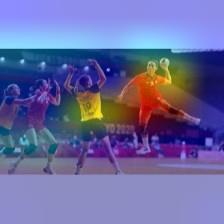

1/1 [==============================] - 0s 20ms/step
Predicted: Handball | Actual: Handball 


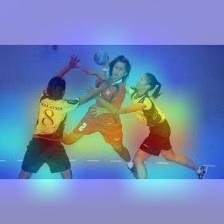

1/1 [==============================] - 0s 21ms/step
Predicted: Handball | Actual: Handball 


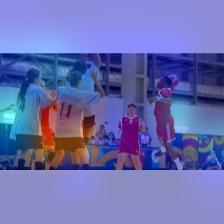

1/1 [==============================] - 0s 22ms/step
Predicted: Sepak Trakaw | Actual: Sepak Trakaw 


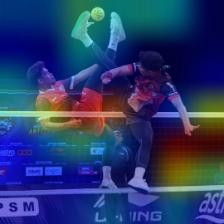

1/1 [==============================] - 0s 18ms/step
Predicted: Kendo | Actual: Kendo 


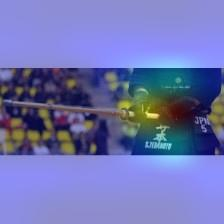

In [36]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
          last_conv_layer_output, preds = grad_model(img_array)
          if pred_index is None:
              pred_index = tf.argmax(preds[0])
          class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.8):
      img = img_path

      # Rescale heatmap to a range 0-255
      heatmap = np.uint8(255 * heatmap)

      # Use jet colormap to colorize heatmap
      jet = cmp.get_cmap("jet")

      # Use RGB values of the colormap
      jet_colors = jet(np.arange(256))[:, :3]
      jet_heatmap = jet_colors[heatmap]

      # Create an image with RGB colorized heatmap
      jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
      jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
      jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

      # Superimpose the heatmap on original image
      superimposed_img = jet_heatmap * alpha + img
      superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

      # Save the superimposed image
      superimposed_img.save(cam_path)

      # Display Grad CAM
      display(Image(cam_path))

for i in range(5):
  c= np.random.randint(0,119)
  img_path = x_test[c]
  img_array = preprocess_input(img_path)
  model.layers[-1].activation = None
  preds = model.predict(img_array.reshape(-1,224,224,3))
  print(f"Predicted: {label[np.argmax(preds)]} | Actual: {label[y_test[c]]} ")
  heatmap = make_gradcam_heatmap(img_array.reshape(1,224,224,3), model, last_conv_layer_name)
  save_and_display_gradcam(img_path, heatmap)